In [4]:
import warnings
warnings.simplefilter('ignore')
!pip remove fbprophet
!pip install pystan==2.19.1.1
!pip install fbprophet
!pip install altair
import pandas as pd
from fbprophet import Prophet
import altair as alt

ERROR: unknown command "remove"
  Using cached pystan-2.19.1.1-cp38-cp38-macosx_10_9_x86_64.whl (37.4 MB)
  Attempting uninstall: pystan
    Found existing installation: pystan 3.0.0
    Uninstalling pystan-3.0.0:
      Successfully uninstalled pystan-3.0.0


In [117]:
def detect_anomalies(forecast):
    #copy ds, fact(df['y']), trend, yhat, yhat_lower and yhat_upper
    forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper','fact']].copy()
    #find anomalies
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
    
    #anomaly importace
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecasted['fact']
    forecasted.loc[forecasted['anomaly'] == -1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecasted['fact']
    
    return forecasted

def plot_anomalies(forecasted, name):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color="#7FC97F").encode(
    x=alt.X('ds:T', title='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
    title='Anomaly Detection, ' + name
    )
    
    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color='Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='atrazine'),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()
    
    anomalies = alt.Chart(forecasted[forecasted.anomaly !=0]).mark_circle(size=30, color="Red").encode(
        x='ds:T',
        y=alt.Y('fact', title='atrazine'),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size=alt.Size('importance', legend=None)
    ).interactive()
    
    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
   
  
    

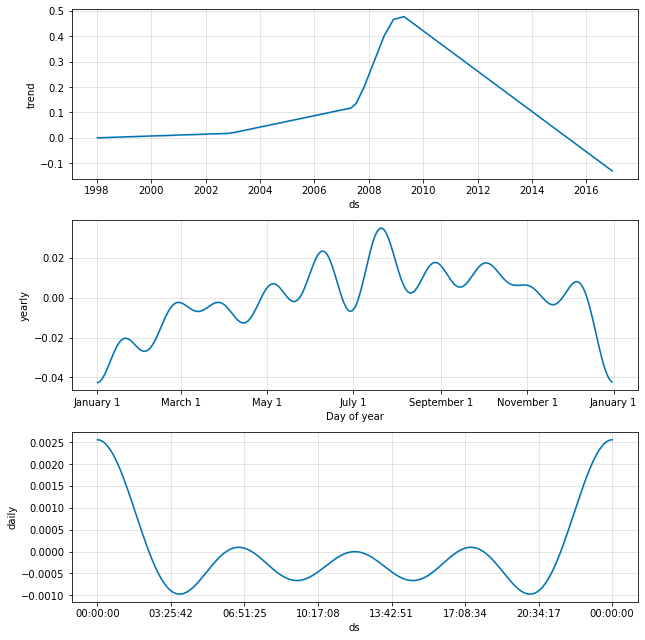

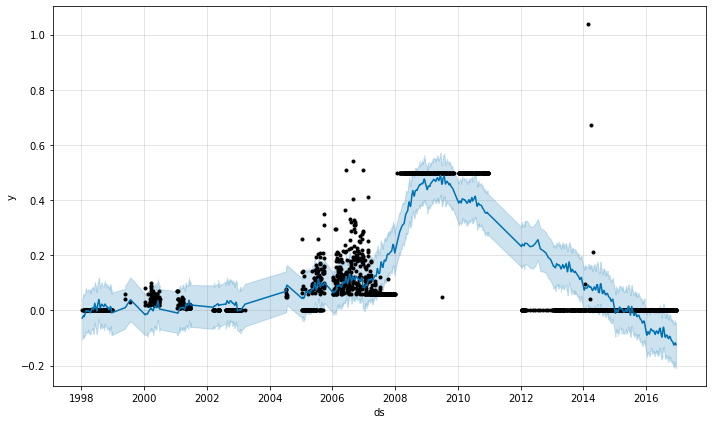

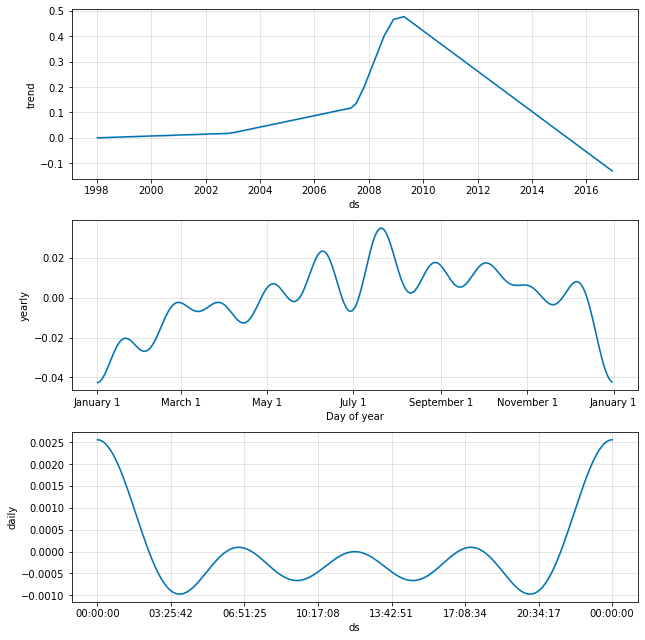

In [154]:
df = pd.read_csv('./MC2/Atrazine.csv')
name = 'All'
df=df[:5000]
# df=df[df['location']==name]
df.drop(['id', 'location', 'measure'], axis=1, inplace=True)
df.columns = ['y', 'ds']
df['ds'] = pd.DatetimeIndex(df['ds'])
m = Prophet(interval_width=0.6, changepoint_range=0.6, daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=True)
model = m.fit(df)
forecast = m.predict(df)
forecast['fact'] = df['y'].reset_index(drop=True)
m.plot(forecast)
forecasted_with_anomalies=detect_anomalies(forecast)
plot_anomalies(forecasted_with_anomalies, name)
m.plot_components(forecast)
# forecasted_with_anomalies.to_csv("./anomalies/iron/"+name+".csv")


In [125]:
df.shape

(2137, 2)

In [130]:
from fbprophet.diagnostics import cross_validation

In [135]:
cv = cross_validation(m, initial='100 days', period='180 days', horizon='100 days')

INFO:fbprophet:Making 32 forecasts with cutoffs between 1998-09-10 00:00:00 and 2016-09-03 00:00:00


In [136]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1998-09-20,0.0,-8.568621e-10,9.926216e-10,0.0,1998-09-10
1,1998-09-20,0.0,-8.961622e-10,1.011517e-09,0.0,1998-09-10
2,1998-09-20,0.0,-8.621806e-10,1.053321e-09,0.0,1998-09-10
3,1998-09-27,0.0,-1.153522e-09,1.213205e-09,0.0,1998-09-10
4,1998-09-27,0.0,-1.219773e-09,1.183846e-09,0.0,1998-09-10


In [138]:
from fbprophet.diagnostics import performance_metrics

In [139]:
df_pm = performance_metrics(cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [140]:
df_pm

,horizon,mse,rmse,mae,mdape,coverage
0,7 days,0.017533,0.132412,0.086633,1.361624,0.387719
1,8 days,0.019393,0.139258,0.088481,1.356336,0.398246
2,9 days,0.018452,0.135837,0.088793,1.361624,0.397807
3,10 days,0.017779,0.133339,0.086488,NaN,0.398947
4,11 days,0.017772,0.133310,0.087140,NaN,0.379649
...,...,...,...,...,...,...
89,96 days,0.020610,0.143563,0.104076,NaN,0.334928
90,97 days,0.020401,0.142831,0.103713,NaN,0.330681
91,98 days,0.018132,0.134655,0.099810,NaN,0.312729
92,99 days,0.018703,0.136760,0.099831,NaN,0.326601


In [141]:
from fbprophet.plot import plot_cross_validation_metric

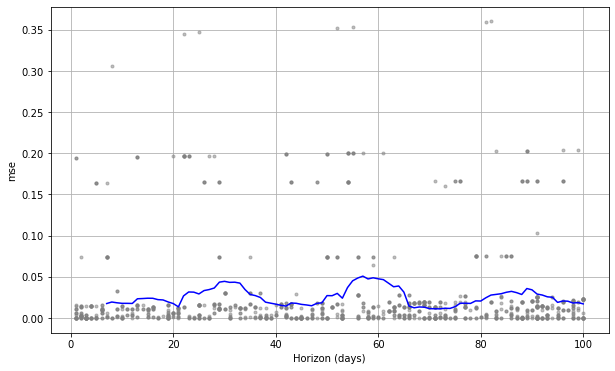

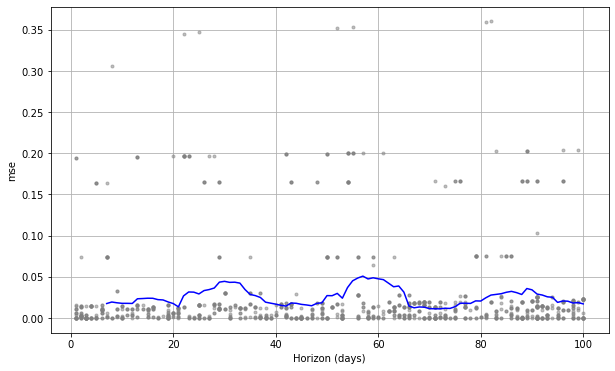

In [151]:
plot_cross_validation_metric(cv, metric="mse")